In [7]:
def expo_func(x):
    return (-(x-30)/30)**2

def expo_func2(x):
    return ((x-70)/30)**2


for x in [70,85,100]:
    print(expo_func2(x))

0.0
0.25
1.0


In [1]:
import akshare as ak
import backtrader as bt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

C:\Users\Jinze Wang\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [ ]:
# 准备股票数据
stock_data = ak.stock_zh_a_hist(
    symbol='002085', 
    period='daily',
    start_date='20240101', 
    end_date='20250822', 
    adjust='qfq'
)

# 重命名列以符合backtrader要求
stock_data = stock_data[['日期', '开盘', '收盘', '最高', '最低', '成交量']]
stock_data.columns = ['datetime', 'open', 'close', 'high', 'low', 'volume']
stock_data['datetime'] = pd.to_datetime(stock_data['datetime'])
stock_data.set_index('datetime', inplace=True)
stock_data = stock_data.sort_index()

# 确保数据类型正确
for col in ['open', 'close', 'high', 'low', 'volume']:
    stock_data[col] = pd.to_numeric(stock_data[col], errors='coerce')

# 删除包含NaN的行
stock_data = stock_data.dropna()

# stock_data

In [11]:
class Person():
    def __init__(self):
        print('init called')


tom = Person()

init called


In [ ]:

RSI_list=[]
price_list=[]
class RSIStrategy(bt.Strategy):
    """RSI策略：超买超卖策略"""
    params = (
        ('rsi_period', 14),      # RSI周期
        ('oversold', 30),        # 超卖阈值
        ('overbought', 70),      # 超买阈值
    )
    

    def __init__(self):
        print(self.datas[0].close)
        self.rsi = bt.indicators.RSI(self.datas[0].close, period=self.params.rsi_period)
        self.order = None
        self.trades = []  # 记录交易
        # self.rsi_list = []
        
        
    def next(self):
        # if self.order:
        #     return
        batch_size = 100
        RSI_list.append(self.rsi[0])
        price_list.append(self.datas[0].close[0])
        print()
        if not self.position:  # 没有持仓 -- 判断是否买入
            
            if self.rsi[0] < self.params.oversold:  # RSI超卖，买入信号
                # 检查资金是否足够
                if self.broker.getcash() >= self.datas[0].close[0] * 100:
                    # 算一下最多买多少手
                    max_count = self.broker.getcash()//(self.datas[0].close[0] * 100)
                    self.order = self.buy(size=max_count*100)
                    self.trades.append({
                        'date': self.datas[0].datetime.date(0),
                        'type': '买入',
                        'price': self.datas[0].close[0],
                        'rsi': self.rsi[0]
                    })
                    print("买入:",self.datas[0].datetime.date(0),self.datas[0].close[0],self.rsi[0])

        else:  # 已有持仓 -- 应该判断是否买入/卖出
            if self.rsi[0] > self.params.overbought:  # RSI超买，卖出信号
                self.order = self.sell(size=self.position.size)  # 卖出全部持仓
                self.trades.append({
                    'date': self.datas[0].datetime.date(0),
                    'type': '卖出',
                    'price': self.datas[0].close[0],
                    'rsi': self.rsi[0]
                })
                print("卖出:",self.datas[0].datetime.date(0),self.datas[0].close[0],self.rsi[0])


In [ ]:
# 五年期国债收益率 5%


In [ ]:
cerebro = bt.Cerebro()
# 添加数据
datafeed = bt.feeds.PandasData(dataname=stock_data)
cerebro.adddata(datafeed)
# datafeed2 = ...
# cerebro.adddata(datafeed2)

# 设置初始资金
initial_cash = 300000
cerebro.broker.setcash(initial_cash)

# 设置手续费
cerebro.broker.setcommission(commission=0.00005)  

# 添加策略
cerebro.addstrategy(RSIStrategy)

# 添加分析器
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')

# 运行回测
results = cerebro.run()
strategy = results[0]

# 获取分析结果
sharpe = strategy.analyzers.sharpe.get_analysis()
drawdown = strategy.analyzers.drawdown.get_analysis()
returns = strategy.analyzers.returns.get_analysis()
trades = strategy.analyzers.trades.get_analysis()


# 计算交易统计
total_trades = trades.get('total', {}).get('total', 0) if trades else 0
won_trades = trades.get('won', {}).get('total', 0) if trades else 0
win_rate = (won_trades / total_trades * 100) if total_trades > 0 else 0

final_value = strategy.broker.getvalue()
total_return = (final_value - initial_cash) / initial_cash * 100


print(f"  RSI 完成 - 总收益率: {total_return:.2f}%, 夏普比率: {sharpe.get('sharperatio', 0):.4f}, 交易次数: {total_trades}")

买入: 2024-07-24 11.1 29.31302901574574
卖出: 2024-10-08 16.3 74.83653859352361
买入: 2025-04-07 15.3 22.94682754363049
  RSI 完成 - 总收益率: 62.79%, 夏普比率: 2.4105, 交易次数: 2


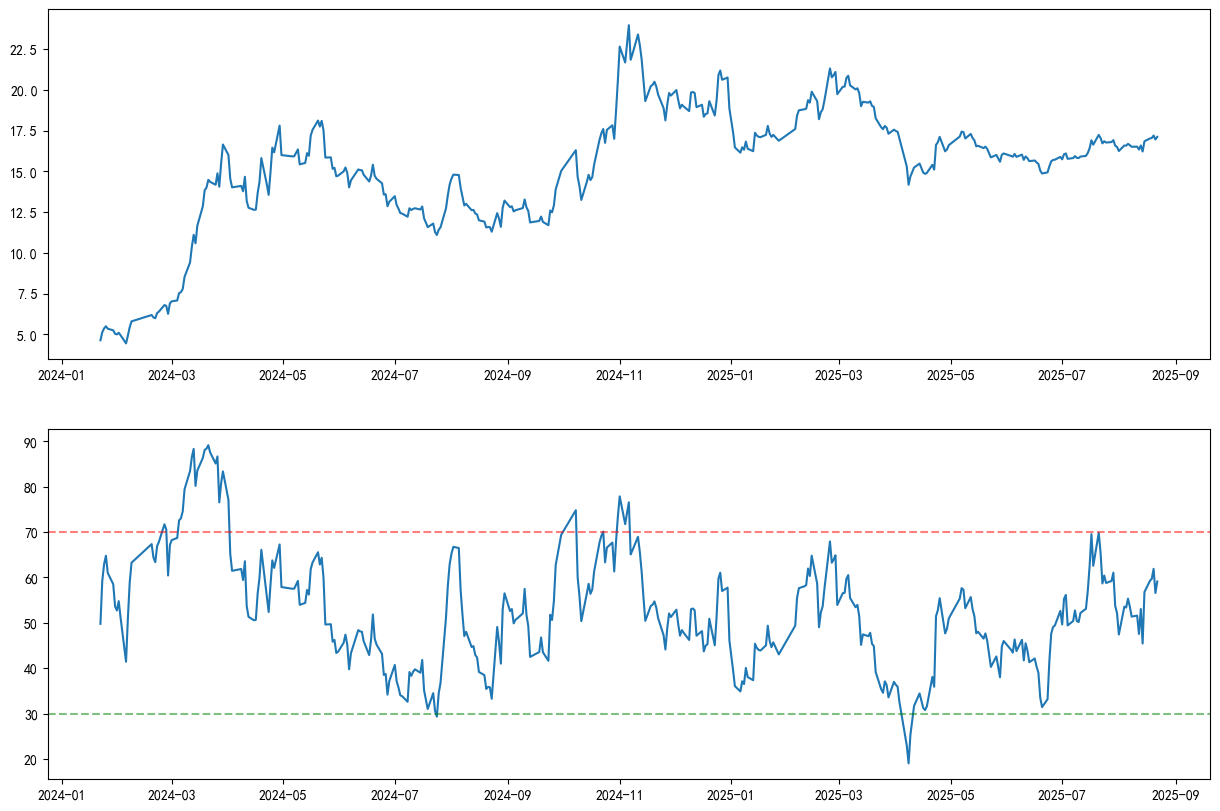

In [58]:
# 在一张图中，画出股价和RSI的实时变动，同时在图中标注出买卖点。
# RSI_list
# price_list

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

ax1.plot(list(stock_data.index)[14:],price_list)
ax2.plot(list(stock_data.index)[14:],RSI_list)
ax2.axhline(y=30, color='green', linestyle='--', alpha=0.5)
ax2.axhline(y=70, color='red', linestyle='--', alpha=0.5)

In [29]:
def plot_individual_strategy(data, strategy_results):
    """
    绘制每个策略的详细图表
    """
    try:
        if not strategy_results:
            print("警告：没有策略结果数据")
            return
            
        for result in strategy_results:
            name = result['name']
            trades = result.get('trades', [])
            
            # 创建子图
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
            fig.suptitle(f'{name} - 详细分析', fontsize=16)
            
            # 第一个子图：价格和指标
            ax1.plot(data.index, data['close'], label='收盘价', color='black', alpha=0.7)
            
            # 标注买卖点
            if trades:
                buy_dates = []
                buy_prices = []
                sell_dates = []
                sell_prices = []
                
                for trade in trades:
                    if trade['type'] == '买入':
                        buy_dates.append(trade['date'])
                        buy_prices.append(trade['price'])
                    elif trade['type'] == '卖出':
                        sell_dates.append(trade['date'])
                        sell_prices.append(trade['price'])
                
                # 绘制买卖点
                if buy_dates:
                    ax1.scatter(buy_dates, buy_prices, color='red', marker='^', s=100, label='买入点', zorder=5)
                if sell_dates:
                    ax1.scatter(sell_dates, sell_prices, color='green', marker='v', s=100, label='卖出点', zorder=5)
            
            # 根据策略类型添加相应指标
            if 'RSI' in name:
                # 使用pandas计算RSI
                delta = data['close'].diff()
                gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
                loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
                rs = gain / loss
                rsi = 100 - (100 / (1 + rs))
                
                ax1_twin = ax1.twinx()
                ax1_twin.plot(data.index, rsi, label='RSI', color='red', alpha=0.7)
                ax1_twin.axhline(y=30, color='green', linestyle='--', alpha=0.5)
                ax1_twin.axhline(y=70, color='red', linestyle='--', alpha=0.5)
                ax1_twin.set_ylabel('RSI')
                ax1_twin.legend()
                
            elif 'MACD' in name:
                # 使用pandas计算MACD
                exp1 = data['close'].ewm(span=12).mean()
                exp2 = data['close'].ewm(span=26).mean()
                macd_line = exp1 - exp2
                signal_line = macd_line.ewm(span=9).mean()
                
                ax1_twin = ax1.twinx()
                ax1_twin.plot(data.index, macd_line, label='MACD', color='blue', alpha=0.7)
                ax1_twin.plot(data.index, signal_line, label='Signal', color='red', alpha=0.7)
                ax1_twin.set_ylabel('MACD')
                ax1_twin.legend()
                
            elif '布林带' in name:
                # 使用pandas计算布林带
                ma20 = data['close'].rolling(window=20).mean()
                std20 = data['close'].rolling(window=20).std()
                upper_band = ma20 + (std20 * 2)
                lower_band = ma20 - (std20 * 2)
                
                ax1.plot(data.index, upper_band, label='上轨', color='red', alpha=0.7)
                ax1.plot(data.index, ma20, label='中轨', color='blue', alpha=0.7)
                ax1.plot(data.index, lower_band, label='下轨', color='green', alpha=0.7)
                
            elif '双均线' in name:
                ma5 = data['close'].rolling(window=5).mean()
                ma20 = data['close'].rolling(window=20).mean()
                ax1.plot(data.index, ma5, label='MA5', color='blue', alpha=0.7)
                ax1.plot(data.index, ma20, label='MA20', color='red', alpha=0.7)
            
            ax1.set_title(f'{name} - 价格与指标')
            ax1.set_ylabel('价格 (元)')
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            
            # 第二个子图：资金曲线
            ax2.plot(data.index, [result['final_value']] * len(data), 
                    label=f'最终资金: {result["final_value"]:,.0f}', 
                    color='green', linewidth=2)
            ax2.set_title(f'{name} - 资金曲线')
            ax2.set_ylabel('资金 (元)')
            ax2.set_xlabel('日期')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
    except Exception as e:
        print(f"绘制单个策略图表时出现错误: {e}")
        print("错误详情：")
        import traceback
        traceback.print_exc()

In [ ]:
class MACDStrategy(bt.Strategy):
    """MACD策略：趋势跟踪策略"""
    params = (
        ('fast_period', 12),     # 快线周期
        ('slow_period', 26),     # 慢线周期
        ('signal_period', 9),    # 信号线周期
    )
    
    def __init__(self):
        self.macd = bt.indicators.MACD(
            self.datas[0].close,
            period_me1=self.params.fast_period,
            period_me2=self.params.slow_period,
            period_signal=self.params.signal_period
        )
        self.order = None
        self.trades = []  # 记录交易
        
    def notify_order(self, order):
        if order.status in [order.Completed, order.Canceled, order.Margin, order.Rejected]:
            self.order = None  # 重置订单状态
        
    def next(self):
        if self.order:
            return
            
        if not self.position:  # 没有持仓
            if (self.macd.macd[0] > self.macd.signal[0] and 
                self.macd.macd[-1] <= self.macd.signal[-1] and
                len(self.macd.macd) > 1):
                # MACD线上穿信号线，买入
                self.order = self.buy(size=100)
                self.trades.append({
                    'date': self.datas[0].datetime.date(0),
                    'type': '买入',
                    'price': self.datas[0].close[0],
                    'macd': self.macd.macd[0],
                    'signal': self.macd.signal[0]
                })
        else:  # 已有持仓
            if (self.macd.macd[0] < self.macd.signal[0] and 
                self.macd.macd[-1] >= self.macd.signal[-1] and
                len(self.macd.macd) > 1):
                # MACD线下穿信号线，卖出
                self.order = self.sell(size=self.position.size)  # 卖出全部持仓
                self.trades.append({
                    'date': self.datas[0].datetime.date(0),
                    'type': '卖出',
                    'price': self.datas[0].close[0],
                    'macd': self.macd.macd[0],
                    'signal': self.macd.signal[0]
                })

,open,close,high,low,volume
datetime,,,,,
2024-01-02,4.69,4.65,4.70,4.64,139008
2024-01-03,4.63,4.58,4.65,4.53,141957
2024-01-04,4.56,4.55,4.56,4.50,105040
2024-01-05,4.54,4.52,4.60,4.48,148362
2024-01-08,4.50,4.36,4.50,4.36,122045
...,...,...,...,...,...
2025-08-18,16.80,17.02,17.18,16.70,988659
2025-08-19,16.98,17.05,17.23,16.72,877363
2025-08-20,17.10,17.20,17.22,16.91,718188


In [ ]:
def run_multi_strategy_backtest(data, initial_cash=1000000):
    """
    运行多策略回测
    """
    # 定义策略列表
    strategies = [
        ('RSI策略', RSIStrategy, {'rsi_period': 14, 'oversold': 30, 'overbought': 70}),
        ('MACD策略', MACDStrategy, {'fast_period': 12, 'slow_period': 26, 'signal_period': 9}),
    ]
    
    # 存储每个策略的结果
    strategy_results = []
    
    print("开始多策略回测...")
    print("=" * 50)
    
    for name, strategy_class, params in strategies:
        print(f"正在运行 {name}...")
        
        try:
            # 创建Cerebro引擎
            cerebro = bt.Cerebro()
            
            # 添加数据
            datafeed = bt.feeds.PandasData(dataname=data)
            cerebro.adddata(datafeed)
            
            # 设置初始资金
            cerebro.broker.setcash(initial_cash)
            
            # 设置手续费
            cerebro.broker.setcommission(commission=0.001)  # 0.1%手续费
            
            # 添加策略
            cerebro.addstrategy(strategy_class, **params)
            
            # 添加分析器
            cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
            cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
            cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
            cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')
            
            # 运行回测
            results = cerebro.run()
            strategy = results[0]
            
            # 获取分析结果
            sharpe = strategy.analyzers.sharpe.get_analysis()
            drawdown = strategy.analyzers.drawdown.get_analysis()
            returns = strategy.analyzers.returns.get_analysis()
            trades = strategy.analyzers.trades.get_analysis()
            
            # 计算交易统计
            total_trades = trades.get('total', {}).get('total', 0) if trades else 0
            won_trades = trades.get('won', {}).get('total', 0) if trades else 0
            win_rate = (won_trades / total_trades * 100) if total_trades > 0 else 0
            
            final_value = strategy.broker.getvalue()
            total_return = (final_value - initial_cash) / initial_cash * 100
            
            strategy_results.append({
                'name': name,
                'final_value': final_value,
                'total_return': total_return,
                'sharpe_ratio': sharpe.get('sharperatio', 0),
                'max_drawdown': drawdown.get('max', {}).get('drawdown', 0),
                'annual_return': returns.get('rnorm100', 0),
                'total_trades': total_trades,
                'win_rate': win_rate,
                'cerebro': cerebro,
                'strategy': strategy,
                'trades': strategy.trades  # 保存交易记录
            })
            
            print(f"  {name} 完成 - 总收益率: {total_return:.2f}%, 夏普比率: {sharpe.get('sharperatio', 0):.4f}, 交易次数: {total_trades}")
            
        except Exception as e:
            print(f"  {name} 运行失败: {e}")
            # 添加默认结果
            strategy_results.append({
                'name': name,
                'final_value': initial_cash,
                'total_return': 0.0,
                'sharpe_ratio': 0.0,
                'max_drawdown': 0.0,
                'annual_return': 0.0,
                'total_trades': 0,
                'win_rate': 0.0,
                'cerebro': None,
                'strategy': None,
                'trades': []
            })
    
    return strategy_results